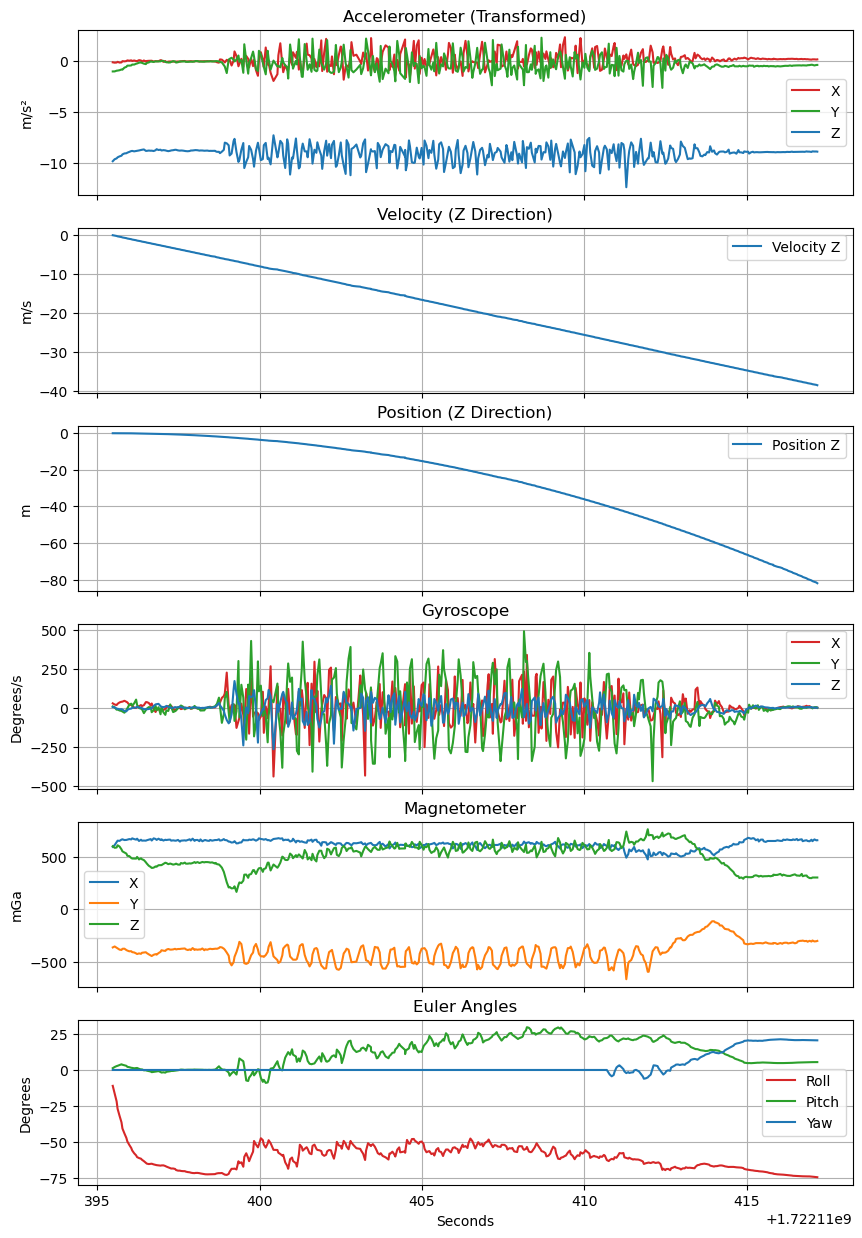

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imufusion
import sys

# Function to parse the date and time from the string
def parse_timestamp(date_str):
    return pd.to_datetime(date_str, format='%d/%m/%Y %H:%M:%S.%f').timestamp()

# Function to read and process data files
def read_sensor_data(filename, sensor_type):
    data = pd.read_csv(filename, skiprows=4)
    
    if sensor_type == 'accelerometer':
        relevant_columns = ['Date', 'X (mg)', 'Y (mg)', 'Z (mg)']
    elif sensor_type == 'magnetometer':
        relevant_columns = ['Date', 'X (mGa)', 'Y (mGa)', 'Z (mGa)']
    elif sensor_type == 'gyroscope':
        relevant_columns = ['Date', 'X (dps)', 'Y (dps)', 'Z (dps)']
    else:
        raise ValueError(f"Unknown sensor type: {sensor_type}")

    data = data[relevant_columns]
    data.columns = ['Date', 'X', 'Y', 'Z']
    data['Timestamp'] = data['Date'].apply(parse_timestamp)
    data = data.groupby('Timestamp').agg({'X': 'mean', 'Y': 'mean', 'Z': 'mean'}).reset_index()
    
    return data

# Read and process all sensor data files
accel_data = read_sensor_data('accel100.csv', 'accelerometer')
gyro_data = read_sensor_data('gyro100.csv', 'gyroscope')
mag_data = read_sensor_data('mag100.csv', 'magnetometer')

# Align timestamps
timestamps = np.intersect1d(accel_data['Timestamp'], gyro_data['Timestamp'])
timestamps = np.intersect1d(timestamps, mag_data['Timestamp'])

def align_data(df, timestamps):
    df = df.set_index('Timestamp')
    df = df.reindex(timestamps).interpolate(method='linear').bfill().reset_index()
    return df

accel_data_aligned = align_data(accel_data, timestamps)
gyro_data_aligned = align_data(gyro_data, timestamps)
mag_data_aligned = align_data(mag_data, timestamps)

# Extract sensor data
timestamp = accel_data_aligned['Timestamp'].values
accelerometer = accel_data_aligned[['X', 'Y', 'Z']].values / 1000  # Convert mg to g
gyroscope = gyro_data_aligned[['X', 'Y', 'Z']].values

# Apply Madgwick filter to compute orientation
ahrs = imufusion.Ahrs()
euler = np.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], 1 / 100)  # 100 Hz sample rate
    euler[index] = ahrs.quaternion.to_euler()

# Function to apply rotation based on Euler angles
def apply_euler_rotation(data, euler_angles):
    rotated_data = np.empty_like(data)
    for i in range(len(data)):
        roll, pitch, yaw = np.radians(euler_angles[i])  # Convert degrees to radians
        R_roll = np.array([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)]
        ])
        R_pitch = np.array([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])
        R_yaw = np.array([
            [np.cos(yaw), -np.sin(yaw), 0],
            [np.sin(yaw), np.cos(yaw), 0],
            [0, 0, 1]
        ])
        R = R_yaw @ R_pitch @ R_roll
        rotated_data[i] = R @ data[i]
    return rotated_data

# Apply rotation to accelerometer data to remove gravity
accelerometer_transformed = apply_euler_rotation(accelerometer, euler)

# Remove gravity (assuming gravity points in the Z direction)
# Gravity is approximately 9.81 m/s² in the Z direction
accelerometer_transformed[:, 2] -= 9.81

# Dead reckoning calculations with transformed data
def dead_reckoning(accel_data, delta_t):
    velocity = np.zeros_like(accel_data)
    position = np.zeros_like(accel_data)
    
    for i in range(1, len(accel_data)):
        velocity[i] = velocity[i-1] + accel_data[i-1] * delta_t
        position[i] = position[i-1] + velocity[i-1] * delta_t
    
    return velocity, position

# Assuming a sample rate of 100 Hz
delta_t = 1 / 100

# Compute velocity and position using transformed accelerometer data
velocity = np.zeros((len(timestamp), 3))
position = np.zeros((len(timestamp), 3))
velocity[:, 2], position[:, 2] = dead_reckoning(accelerometer_transformed[:, 2], delta_t)

# Plot sensor data
fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(10, 15))

# Plot Accelerometer Data (Transformed)
axes[0].plot(timestamp, accelerometer_transformed[:, 0], "tab:red", label="X")
axes[0].plot(timestamp, accelerometer_transformed[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp, accelerometer_transformed[:, 2], "tab:blue", label="Z")
axes[0].set_title("Accelerometer (Transformed)")
axes[0].set_ylabel("m/s²")
axes[0].grid()
axes[0].legend()

# Plot Velocity Data
axes[1].plot(timestamp, velocity[:, 2], "tab:blue", label="Velocity Z")
axes[1].set_title("Velocity (Z Direction)")
axes[1].set_ylabel("m/s")
axes[1].grid()
axes[1].legend()

# Plot Position Data
axes[2].plot(timestamp, position[:, 2], "tab:blue", label="Position Z")
axes[2].set_title("Position (Z Direction)")
axes[2].set_ylabel("m")
axes[2].grid()
axes[2].legend()

# Plot Gyroscope Data
axes[3].plot(timestamp, gyroscope[:, 0], "tab:red", label="X")
axes[3].plot(timestamp, gyroscope[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp, gyroscope[:, 2], "tab:blue", label="Z")
axes[3].set_title("Gyroscope")
axes[3].set_ylabel("Degrees/s")
axes[3].grid()
axes[3].legend()

# Plot Magnetometer Data
axes[4].plot(timestamp, mag_data_aligned[['X', 'Y', 'Z']].values, label=['X', 'Y', 'Z'])
axes[4].set_title("Magnetometer")
axes[4].set_ylabel("mGa")
axes[4].grid()
axes[4].legend()

# Plot Euler angles
axes[5].plot(timestamp, euler[:, 0], "tab:red", label="Roll")
axes[5].plot(timestamp, euler[:, 1], "tab:green", label="Pitch")
axes[5].plot(timestamp, euler[:, 2], "tab:blue", label="Yaw")
axes[5].set_title("Euler Angles")
axes[5].set_xlabel("Seconds")
axes[5].set_ylabel("Degrees")
axes[5].grid()
axes[5].legend()

plt.show(block="no_block" not in sys.argv)  # don't block when script run by CI


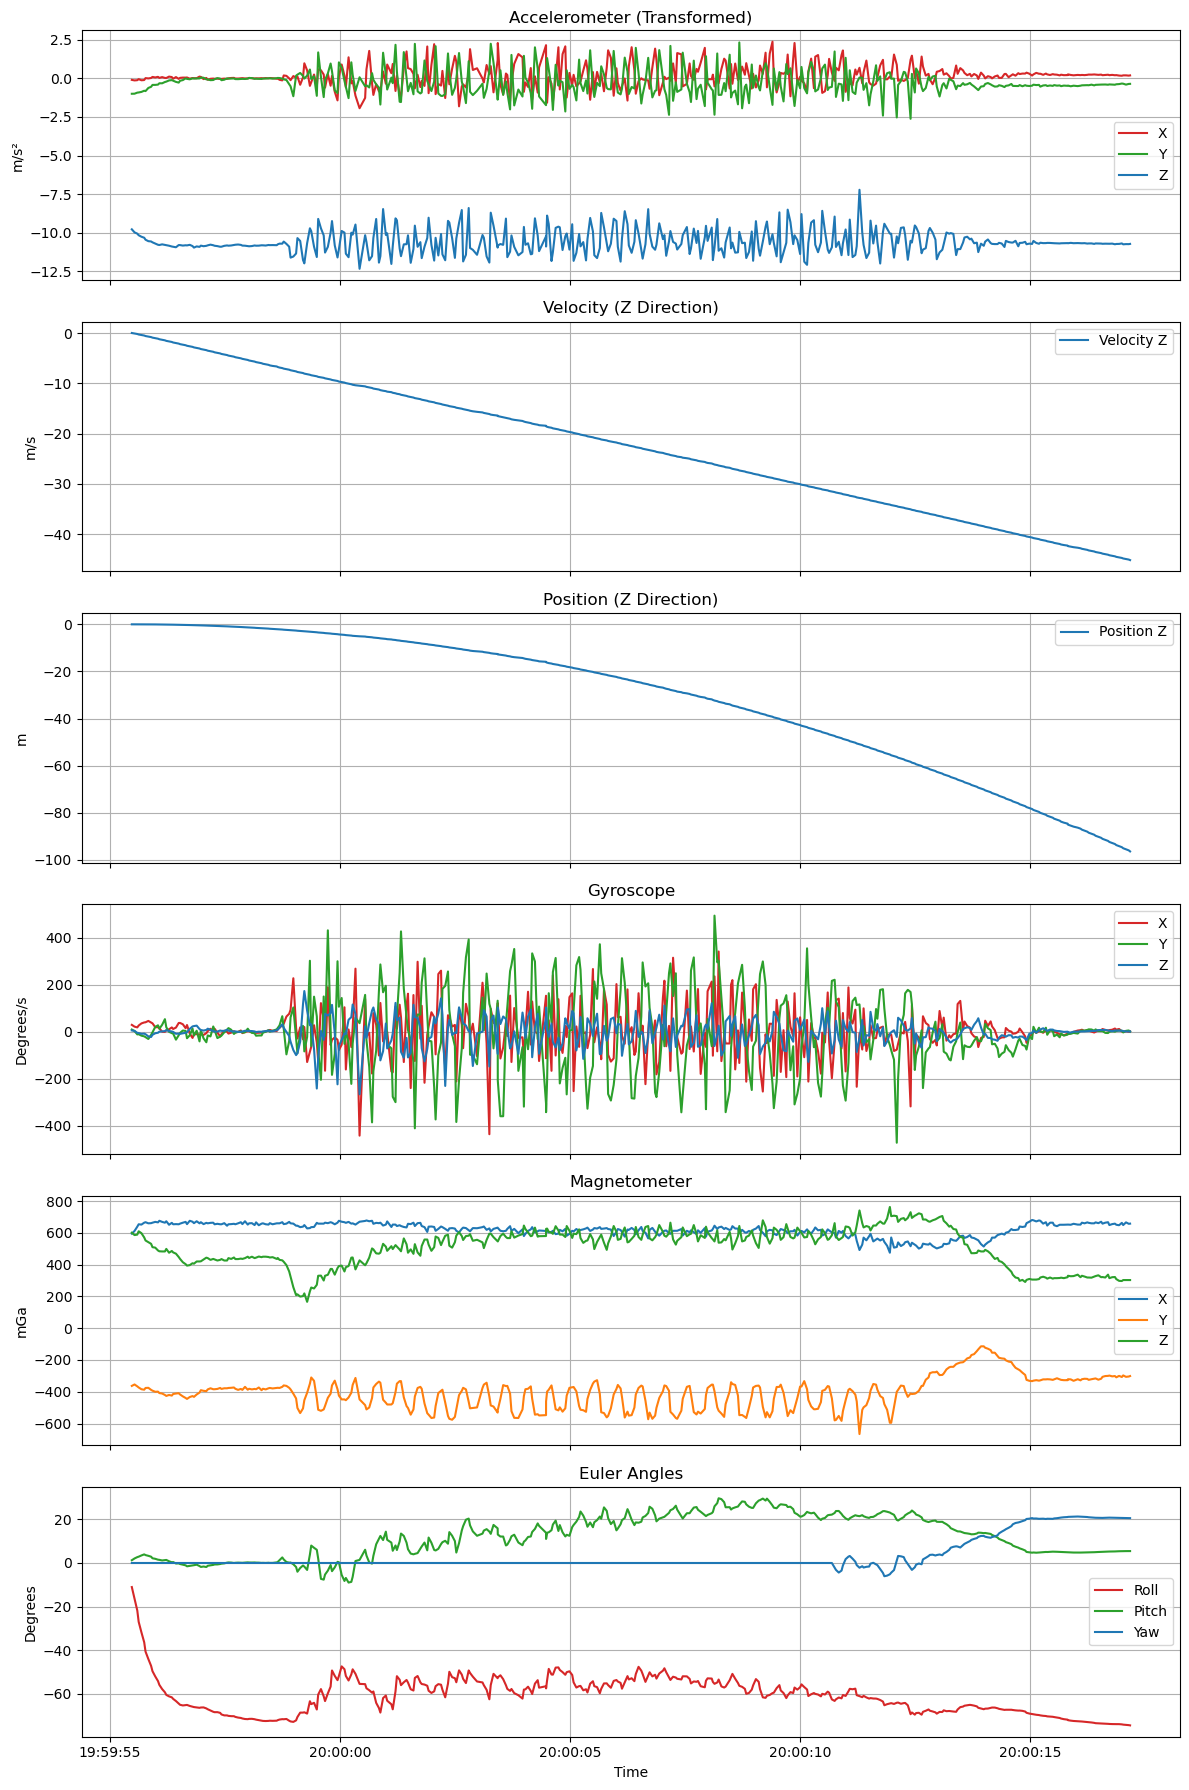

In [27]:
#try 3


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import imufusion
import sys

# Function to parse the date and time from the string
def parse_timestamp(date_str):
    return pd.to_datetime(date_str, format='%d/%m/%Y %H:%M:%S.%f').timestamp()

# Function to read and process data files
def read_sensor_data(filename, sensor_type):
    data = pd.read_csv(filename, skiprows=4)
    
    if sensor_type == 'accelerometer':
        relevant_columns = ['Date', 'X (mg)', 'Y (mg)', 'Z (mg)']
    elif sensor_type == 'magnetometer':
        relevant_columns = ['Date', 'X (mGa)', 'Y (mGa)', 'Z (mGa)']
    elif sensor_type == 'gyroscope':
        relevant_columns = ['Date', 'X (dps)', 'Y (dps)', 'Z (dps)']
    else:
        raise ValueError(f"Unknown sensor type: {sensor_type}")

    data = data[relevant_columns]
    data.columns = ['Date', 'X', 'Y', 'Z']
    data['Timestamp'] = data['Date'].apply(parse_timestamp)
    data = data.groupby('Timestamp').agg({'X': 'mean', 'Y': 'mean', 'Z': 'mean'}).reset_index()
    
    return data

# Read and process all sensor data files
accel_data = read_sensor_data('accel100.csv', 'accelerometer')
gyro_data = read_sensor_data('gyro100.csv', 'gyroscope')
mag_data = read_sensor_data('mag100.csv', 'magnetometer')

# Align timestamps
timestamps = np.intersect1d(accel_data['Timestamp'], gyro_data['Timestamp'])
timestamps = np.intersect1d(timestamps, mag_data['Timestamp'])

def align_data(df, timestamps):
    df = df.set_index('Timestamp')
    df = df.reindex(timestamps).interpolate(method='linear').bfill().reset_index()
    return df

accel_data_aligned = align_data(accel_data, timestamps)
gyro_data_aligned = align_data(gyro_data, timestamps)
mag_data_aligned = align_data(mag_data, timestamps)

# Extract sensor data
timestamp = accel_data_aligned['Timestamp'].values
accelerometer = accel_data_aligned[['X', 'Y', 'Z']].values / 1000  # Convert mg to g
gyroscope = gyro_data_aligned[['X', 'Y', 'Z']].values

# Apply Madgwick filter to compute orientation
ahrs = imufusion.Ahrs()
euler = np.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], 1 / 100)  # 100 Hz sample rate
    euler[index] = ahrs.quaternion.to_euler()

# Function to apply rotation based on Euler angles
def apply_euler_rotation(data, euler_angles):
    rotated_data = np.empty_like(data)
    for i in range(len(data)):
        roll, pitch, yaw = np.radians(euler_angles[i])  # Convert degrees to radians
        R_roll = np.array([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)]
        ])
        R_pitch = np.array([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])
        R_yaw = np.array([
            [np.cos(yaw), -np.sin(yaw), 0],
            [np.sin(yaw), np.cos(yaw), 0],
            [0, 0, 1]
        ])
        R = R_yaw @ R_pitch @ R_roll
        rotated_data[i] = R @ data[i]
    return rotated_data

# Apply rotation to accelerometer data to remove gravity
accelerometer_transformed = apply_euler_rotation(accelerometer, euler)

# Invert the Z-axis to correct for IMU orientation
accelerometer_transformed[:, 2] = -accelerometer_transformed[:, 2]

# Remove gravity (assuming gravity points in the Z direction)
# Gravity is approximately 9.81 m/s² in the Z direction
accelerometer_transformed[:, 2] -= 9.81

# Dead reckoning calculations with transformed data
def dead_reckoning(accel_data, delta_t):
    velocity = np.zeros_like(accel_data)
    position = np.zeros_like(accel_data)
    
    for i in range(1, len(accel_data)):
        velocity[i] = velocity[i-1] + accel_data[i-1] * delta_t
        position[i] = position[i-1] + velocity[i-1] * delta_t
    
    return velocity, position

# Assuming a sample rate of 100 Hz
delta_t = 1 / 100

# Compute velocity and position using transformed accelerometer data
velocity = np.zeros((len(timestamp), 3))
position = np.zeros((len(timestamp), 3))
velocity[:, 2], position[:, 2] = dead_reckoning(accelerometer_transformed[:, 2], delta_t)

# Convert timestamps to datetime for plotting
timestamp_datetime = pd.to_datetime(timestamp, unit='s')

# Plot sensor data
fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(12, 18))

# Plot Accelerometer Data (Transformed)
axes[0].plot(timestamp_datetime, accelerometer_transformed[:, 0], "tab:red", label="X")
axes[0].plot(timestamp_datetime, accelerometer_transformed[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp_datetime, accelerometer_transformed[:, 2], "tab:blue", label="Z")
axes[0].set_title("Accelerometer (Transformed)")
axes[0].set_ylabel("m/s²")
axes[0].grid()
axes[0].legend()

# Plot Velocity Data
axes[1].plot(timestamp_datetime, velocity[:, 2], "tab:blue", label="Velocity Z")
axes[1].set_title("Velocity (Z Direction)")
axes[1].set_ylabel("m/s")
axes[1].grid()
axes[1].legend()

# Plot Position Data
axes[2].plot(timestamp_datetime, position[:, 2], "tab:blue", label="Position Z")
axes[2].set_title("Position (Z Direction)")
axes[2].set_ylabel("m")
axes[2].grid()
axes[2].legend()

# Plot Gyroscope Data
axes[3].plot(timestamp_datetime, gyroscope[:, 0], "tab:red", label="X")
axes[3].plot(timestamp_datetime, gyroscope[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp_datetime, gyroscope[:, 2], "tab:blue", label="Z")
axes[3].set_title("Gyroscope")
axes[3].set_ylabel("Degrees/s")
axes[3].grid()
axes[3].legend()

# Plot Magnetometer Data
axes[4].plot(timestamp_datetime, mag_data_aligned[['X', 'Y', 'Z']].values, label=['X', 'Y', 'Z'])
axes[4].set_title("Magnetometer")
axes[4].set_ylabel("mGa")
axes[4].grid()
axes[4].legend()

# Plot Euler angles
axes[5].plot(timestamp_datetime, euler[:, 0], "tab:red", label="Roll")
axes[5].plot(timestamp_datetime, euler[:, 1], "tab:green", label="Pitch")
axes[5].plot(timestamp_datetime, euler[:, 2], "tab:blue", label="Yaw")
axes[5].set_title("Euler Angles")
axes[5].set_xlabel("Time")
axes[5].set_ylabel("Degrees")
axes[5].grid()
axes[5].legend()

# Set x-axis format
axes[5].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show(block="no_block" not in sys.argv)  # don't block when script run by CI
